In [138]:
import pandas as pd
import numpy as np
import pricey as pr
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
import seaborn as sns
import arviz as az
from pandas.tseries.offsets import MonthEnd

from sklearnex import patch_sklearn
patch_sklearn()

# import warnings
# warnings.filterwarnings(action='ignore')

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

import pymc as pm
# import aesara as asr
from aesara import shared
import pytensor

# az.style.use("arviz-darkgrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code'])

In [3]:
_dflist = [fdr.DataReader(code, '2019-01-01') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [4]:
p = pd.concat([_s['Close'] for _s in _dflist], axis=1)
p.columns = univ
logp = np.log(p); p.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-10,65700,55800,90700,749000,343000,750000,341500,185900,94000,193000,...,169700,79900,8940,16210,33140,14055,14665,13015,11915,112700
2023-04-11,65900,55300,91800,767000,369500,806000,382500,192100,95700,199900,...,169800,79700,9060,17520,33575,14295,14615,13055,11940,112550
2023-04-12,66000,55600,90300,764000,365500,775000,377000,198200,97900,198000,...,166200,77800,9140,17180,33680,13975,14825,13150,11970,112480
2023-04-13,66100,55000,88700,769000,365000,802000,383500,198900,96900,196400,...,166400,77600,9250,17280,33745,13985,15070,13180,11865,112455
2023-04-14,65600,55200,89400,757000,364000,787000,380000,198700,97200,198400,...,166800,78000,9400,17230,33865,14195,14985,13335,11765,112125


In [5]:
p_open = pd.concat([_s['Open'] for _s in _dflist], axis=1)
p_open.columns = univ; p_open.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-10,64800,54700,88700,738000,338500,721000,326000,186000,94000,193300,...,170200,80900,9050,15380,32805,13625,14680,13090,11910,112310
2023-04-11,66200,56000,90700,756000,357000,768000,390000,186600,94100,193300,...,170200,79300,8940,17520,33235,14165,14500,13005,11920,112695
2023-04-12,65800,55300,91900,776000,374500,799000,401500,195000,96000,199300,...,170100,79800,9100,17610,33540,14305,14780,13080,11940,112550
2023-04-13,65600,55100,89500,753000,365500,760000,369000,199000,97800,196200,...,165200,77800,9120,17180,33515,13780,15065,13155,11950,112480
2023-04-14,66600,55700,90100,773000,368500,812000,394000,199500,97200,198700,...,166700,78400,9300,17230,33950,14050,14925,13300,11830,112195


In [162]:
eoms = p.asfreq(freq='M').tail(36).index; eoms

DatetimeIndex(['2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',
               '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31',
               '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
               '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30',
               '2022-12-31', '2023-01-31', '2023-02-28', '2023-03-31'],
              dtype='datetime64[ns]', name='Date', freq='M')

In [129]:
pairs = [
    ['005930', '005935'], # 0 삼성전자
    ['066570', '066575'], # 1 LG전자
    ['006400', '006405'], # 2 삼성SDI
    ['051910', '051915'], # 3 LG화학
    ['005380', '005385'], # 4 현대차
    ['005930', '000660'], # 5 삼성전자-하이닉스
]

_from, _to = '2019-01-01', '2023-04-13'

stock1_name, stock2_name = pairs[5]
orig_data = logp.loc[_from:_to,[stock1_name, stock2_name]]
p_data = p.loc[_from:_to,[stock1_name, stock2_name]]
p_open_data = p_open.loc[_from:_to,[stock1_name, stock2_name]]

stock1 = orig_data[stock1_name]
stock2 = orig_data[stock2_name]

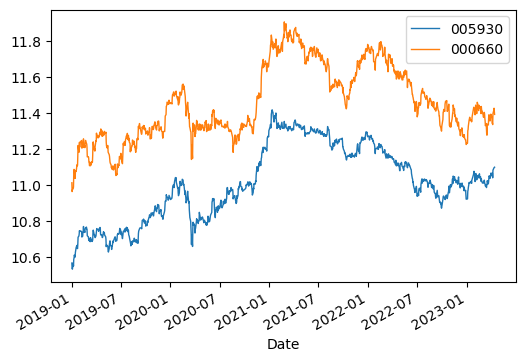

In [130]:
plt.figure(figsize = (6,4))
ax = plt.gca()
orig_data[stock1_name].plot(ax=ax,linewidth=1, fontsize=10)
orig_data[stock2_name].plot(ax=ax,linewidth=1, fontsize=10)
plt.legend()
plt.show()

In [157]:
with pm.Model(coords={'time': orig_data.index.values}) as model:
    sigma_alpha = pm.Exponential('sigma_alpha', 50.0)
    sigma_beta = pm.Exponential('sigma_beta', 50.0)
    
    alpha = pm.GaussianRandomWalk('alpha', sigma=sigma_alpha, init_dist=pm.Normal.dist(0, 10), dims='time')
    beta = pm.GaussianRandomWalk('beta', sigma=sigma_beta, init_dist=pm.Normal.dist(0, 10), dims='time')

In [132]:
with model:
    regression = alpha + beta * stock1
    sd = pm.HalfNormal('sd', sigma=0.1)
    likelihood = pm.Normal('y', mu=regression, sigma=sd, observed=stock2)

In [133]:
with model:
    trace_rw = pm.sample(draws=100, chains=1, cores=8, random_seed=0)
    #trace_rw = pm.sample(tune=2000, target_accept=0.9)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 125 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [164]:
traces = []
for d in tqdm(eoms[:10]):
    stock1 = stock1.loc[:d]
    stock2 = stock2.loc[:d]

    with pm.Model(coords={'time': stock1.index.values}) as model:
        sigma_alpha = pm.Exponential('sigma_alpha', 50.0)
        sigma_beta = pm.Exponential('sigma_beta', 50.0)

        alpha = pm.GaussianRandomWalk('alpha', sigma=sigma_alpha, init_dist=pm.Normal.dist(0, 10), dims='time')
        beta = pm.GaussianRandomWalk('beta', sigma=sigma_beta, init_dist=pm.Normal.dist(0, 10), dims='time')    
    
    with model:
        regression = alpha + beta * stock1
        sd = pm.HalfNormal('sd', sigma=0.1)
        likelihood = pm.Normal('y', mu=regression, sigma=sd, observed=stock2)
        _trace = pm.sample(draws=100, chains=1, cores=8, random_seed=0)
        traces.append(_trace)

  0%|          | 0/10 [00:00<?, ?it/s]

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 94 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 92 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 95 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 92 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 93 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 96 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 95 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 87 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 91 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_alpha, sigma_beta, alpha, beta, sd]


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 90 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [168]:
traces[0].posterior_predictive

AttributeError: 'InferenceData' object has no attribute 'posterior_predictive'

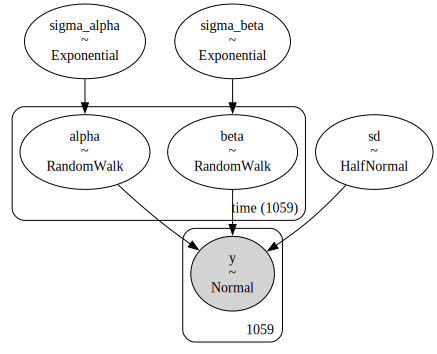

In [33]:
pm.model_to_graphviz(model)

In [136]:
az.extract(trace_rw, var_names='alpha')

<xarray.DataArray 'alpha' (time: 1059, sample: 100)>
array([[ 0.12896566, -0.03291338,  0.11377929, ..., -0.06696007,
        -0.03392794, -0.07862578],
       [ 0.12577468, -0.03491178,  0.11458177, ..., -0.06508653,
        -0.0544392 , -0.08728462],
       [ 0.12720866, -0.03419424,  0.11983486, ..., -0.06325103,
        -0.02907378, -0.08503594],
       ...,
       [ 0.0691824 ,  0.09267441,  0.02338974, ...,  0.16314964,
         0.12171116,  0.22863915],
       [ 0.06779886,  0.08623004,  0.01210205, ...,  0.14507096,
         0.11501801,  0.22503779],
       [ 0.05042375,  0.08301289, -0.00214048, ...,  0.12127006,
         0.11166434,  0.23165182]])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-02 2019-01-03 ... 2023-04-13
  * sample   (sample) object MultiIndex
  * chain    (sample) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99

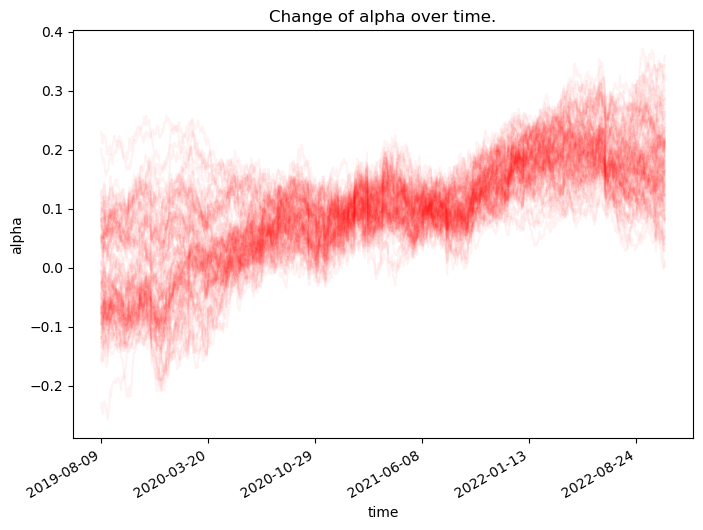

In [125]:
fig = plt.figure(figsize=(8, 6), constrained_layout=False)
ax = plt.subplot(111, xlabel="time", ylabel="alpha", title="Change of alpha over time.")
ax.plot(az.extract(trace_rw, var_names="alpha"), "r", alpha=0.05)

ticks_changes = mticker.FixedLocator(ax.get_xticks().tolist())
ticklabels_changes = [str(p.date()) for p in logp[::len(orig_data) // 7].index]
ax.xaxis.set_major_locator(ticks_changes)
ax.set_xticklabels(ticklabels_changes)

fig.autofmt_xdate()

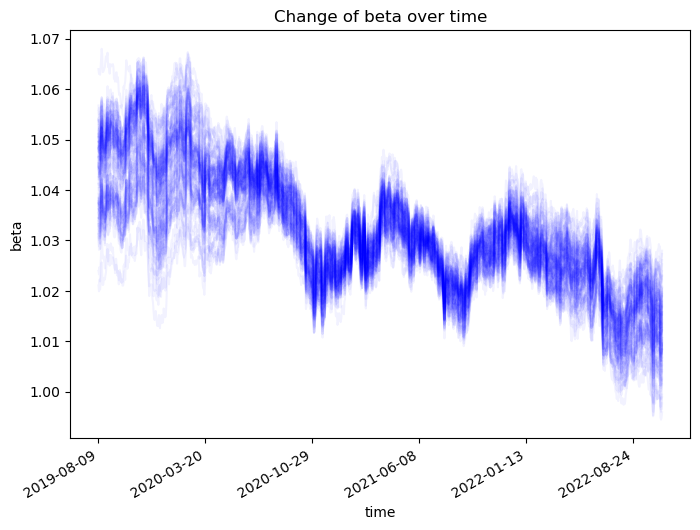

In [126]:
fig = plt.figure(figsize=(8, 6), constrained_layout=False)
ax = fig.add_subplot(111, xlabel="time", ylabel="beta", title="Change of beta over time")
ax.plot(az.extract(trace_rw, var_names="beta"), "b", alpha=0.05)

ax.xaxis.set_major_locator(ticks_changes)
ax.set_xticklabels(ticklabels_changes)

fig.autofmt_xdate()

In [134]:
rolling_alpha = trace_rw.posterior['alpha'].mean(dim=['draw','chain'])
rolling_beta = trace_rw.posterior['beta'].mean(dim=['draw','chain'])

In [87]:
rolling_alpha

<xarray.DataArray 'alpha' (time: 1059)>
array([ 0.28624576,  0.25172117,  0.27708255, ..., -0.63572124,
       -0.71913474, -0.81118189])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-02 2019-01-03 ... 2023-04-13

In [98]:
rolling_alpha

<xarray.DataArray 'alpha' (time: 1055)>
array([ 0.51856709,  0.48761455,  0.52012534, ..., -0.84911707,
       -0.7562812 , -0.69919198])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-02 2019-01-03 ... 2023-04-07

In [108]:
rolling_alpha

<xarray.DataArray 'alpha' (time: 1055)>
array([-0.01484414, -0.01889662, -0.01742805, ...,  0.16712973,
        0.1701482 ,  0.17294474])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-02 2019-01-03 ... 2023-04-07

In [135]:
rolling_alpha

<xarray.DataArray 'alpha' (time: 1059)>
array([-0.10117644, -0.10841275, -0.10143944, ...,  0.14190739,
        0.13275027,  0.12385046])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-02 2019-01-03 ... 2023-04-13

In [109]:
def getStrategyPortfolioWeights(beta, alpha, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1]
    data2 = data[stock_name2]
    
    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(rolling_beta[i])
            fixed_alpha = float(rolling_alpha[i])
            
            signal = fixed_beta*data1 + fixed_alpha - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()
            
            signal_spot[i] = smoothed_signal[i]

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = np.sign(w0 / w_max)
                leverage.iloc[i,1] = np.sign(w1 / w_max)
                                
                trading = "short"
                trading_start = smoothed_signal[i]
                
            elif smoothed_signal[i] < 0 and d_smoothed_signal[i] > 0:
                w0 = fixed_beta / (abs(fixed_beta)+1)
                w1 = -1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = np.sign(w0 / w_max)
                leverage.iloc[i,1] = np.sign(w1 / w_max)
                                
                trading = "long"
                trading_start = smoothed_signal[i]
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                
        elif trading=="long":
            # a failed trade
            if smoothed_signal[i] < trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] > 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
        elif trading=="short":
            signal_spot[i] = smoothed_signal[i]
            
            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage.fillna(0), signal_spot

In [110]:
def backtest(pricingDF, openDF, leverageDF, start_cash):
    pricing = pricingDF.values
    pricing_open = openDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = cash[1] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    
    total_cost = 0
    pnl_hist = np.zeros(pricing.shape[0])
    pnl = []
    values = np.zeros(pricing.shape[0])
    values[0] = values[1] = start_cash

    
    for t in range(2, pricing.shape[0]):
        if np.any(leverage[t-1] != leverage[t-2]):
            target_shares = (start_cash * leverage[t-1] / pricing[t-1]).astype(int)
            
            # rebalance
            shares[t] = target_shares
            cost0 = abs(shares[t,0] - shares[t-1,0]) * pricing_open[t,0] * 0.0001
            #cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * (0.00025 if shares[t,1] > shares[t-1,1] else 0.00225)
            cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * 0.0001

            cash[t] = cash[t-1] - ((shares[t]-shares[t-1]) * pricing_open[t]).sum() - cost0 - cost1
            total_cost += (cost0 + cost1)
            
        else:
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
            
        values[t] = (shares[t] * pricing[t]).sum() + cash[t]
            
        if shares[t-1,0]==0 and shares[t,0]!=0:
            pnl_hist[t] = values[t] - values[t-1]
            
        elif shares[t,0]!=0 or (shares[t-1,0]!=0 and shares[t,0]==0):
            pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]
            
        if shares[t-1,0]!=0 and shares[t,0]==0:
            pnl.append(pnl_hist[t])
    
    
    pct_returns = (values - start_cash) / start_cash
    
    n_days = pct_returns.shape[0]
    net_profit = int(values[-1] - start_cash)
    net_return = pct_returns[-1] * 100
    total_cost_rate = total_cost / (net_profit + total_cost) * 100
    n_entry = len(pnl)
    n_entry_monthly = n_entry / n_days * 20
    n_entry_days = (leverageDF.iloc[:,0] != 0).sum()
    n_holding_days = n_entry_days / n_entry
    pnl_by_entry = net_profit / n_entry
    profit_of_profit_entry = np.mean(list(filter(lambda x: x>0, pnl)))
    loss_of_loss_entry = np.mean(list(filter(lambda x: x<0, pnl)))

    print(f'테스트 일수: {n_days}일')
    print(f'순손익 (투자금액대비%): {format(net_profit, ",")}원 ({net_return:.3f}%)')
    print(f'총비용 (총손익대비%): {format(int(total_cost), ",")}원 ({total_cost_rate:.3f}%)')
    print(f'진입횟수: {n_entry}회')
    print(f'월평균 진입횟수: {n_entry_monthly:.2f}회')
    print(f'진입일수 (전체일수대비%): {n_entry_days}일 ({n_entry_days/n_days*100:.2f}%)')
    print(f'평균보유일수: {n_holding_days:.2f}일')
    print(f'진입당 평균손익: {format(int(pnl_by_entry), ",")}원')
    print(f'최대수익: {format(int(max(pnl)), ",")}원')
    print(f'최대손실: {format(int(min(pnl)), ",")}원')
    print(f'수익진입의 평균수익: {format(int(profit_of_profit_entry), ",")}원')
    print(f'손실진입의 평균손실: {format(int(loss_of_loss_entry), ",")}원')
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index),
        pd.Series(values, index=pricingDF.index),
        pd.Series(pnl_hist, index=pricingDF.index),
        pd.Series(pnl)
    )

테스트 일수: 1055일
순손익 (투자금액대비%): 267,295,176원 (267.295%)
총비용 (총손익대비%): 9,166,023원 (3.315%)
진입횟수: 229회
월평균 진입횟수: 4.34회
진입일수 (전체일수대비%): 231일 (21.90%)
평균보유일수: 1.01일
진입당 평균손익: 1,167,227원
최대수익: 9,793,844원
최대손실: -2,376,675원
수익진입의 평균수익: 1,749,719원
손실진입의 평균손실: -675,563원


<Axes: xlabel='Date'>

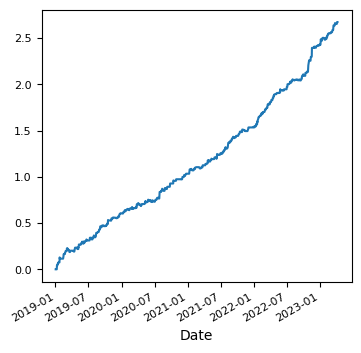

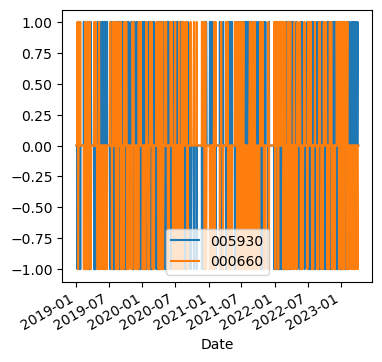

In [112]:
w5, signal5 = getStrategyPortfolioWeights(beta, alpha, stock1_name, stock2_name, orig_data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data, p_open_data, w5, 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)

테스트 일수: 809일
순손익 (투자금액대비%): 195,513,963원 (195.514%)
총비용 (총손익대비%): 6,559,586원 (3.246%)
진입횟수: 164회
월평균 진입횟수: 4.05회
진입일수 (전체일수대비%): 164일 (20.27%)
평균보유일수: 1.00일
진입당 평균손익: 1,192,158원
최대수익: 9,793,844원
최대손실: -2,402,563원
수익진입의 평균수익: 1,674,324원
손실진입의 평균손실: -721,897원


<Axes: xlabel='Date'>

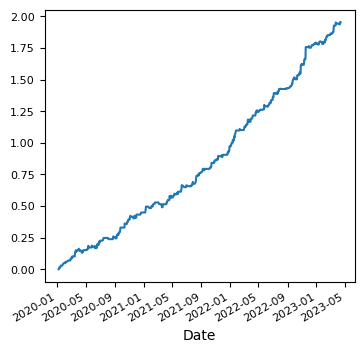

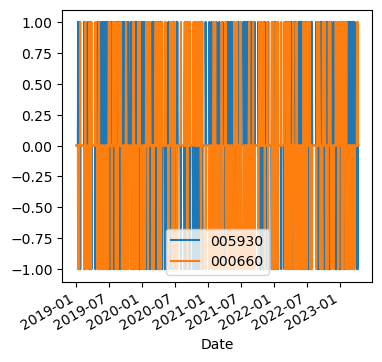

In [77]:
w5, signal5 = getStrategyPortfolioWeights(beta, alpha, stock1_name, stock2_name, data, smoothing_window=1)
shares5, cash5, returns5, values5, pnl_hist5, pnl5 = backtest(p_data[250:], p_open_data[250:], w5[250:], 1e8)
returns5.plot(figsize=(4,4), fontsize=8)
w5.plot(figsize=(4,4), fontsize=10)